## Imports

In [2]:
# Numbers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Graphs
import seaborn as sns

# ML
import sklearn
import sklearn.model_selection
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Pipeline
from sklearn.model_selection import train_test_split # For train/test splits
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline

# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV # For optimization



KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

## Loading Data
[Source](https://www.kaggle.com/discussions/general/74235)

Upload your kaggle.json file for authentication to download the file

In [1]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle competitions download -c ds3-datathon-heart-disease
! unzip "ds3-datathon-heart-disease.zip" -d heart
! rm "ds3-datathon-heart-disease.zip"

  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 16.5MB/s]
Archive:  ds3-datathon-heart-disease.zip
  inflating: heart/heart_sample_submission.csv  
  inflating: heart/heart_test.csv    
  inflating: heart/heart_train.csv   


In [ ]:
data_train = pd.read_csv("/content/heart/heart_train.csv")
data_train_oh = pd.get_dummies(data_train, drop_first=True).iloc[:,2:]

data_test = pd.read_csv("/content/heart/heart_test.csv")
data_test_oh = pd.get_dummies(data_test, drop_first=True).iloc[:,2:]

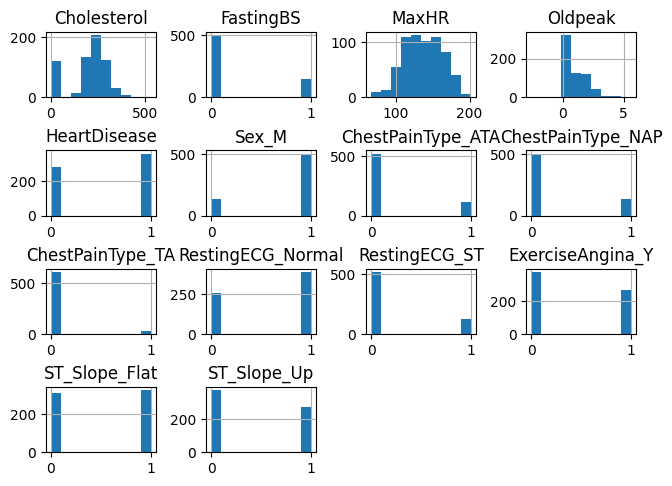

In [ ]:
data_train_oh.iloc[:,2:].hist()
plt.tight_layout( pad = 0.5)

Separating X values for data_train

In [ ]:
data_trainX = data_train_oh.loc[:,data_train_oh.columns != 'HeartDisease']
data_trainX

data_testX = data_test_oh.loc[:,data_test_oh.columns != 'HeartDisease']
data_testX

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,69,122,216,1,84,0.0,1,0,0,0,0,0,1,1,0
1,74,145,216,1,116,1.8,1,0,0,1,1,0,1,1,0
2,66,146,278,0,152,0.0,0,0,1,0,0,0,0,1,0
3,53,144,300,1,128,1.5,1,0,0,0,0,1,1,1,0
4,41,105,198,0,168,0.0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,60,150,258,0,157,2.6,0,0,0,0,0,0,0,1,0
271,58,132,224,0,173,3.2,1,0,1,0,0,0,0,0,1
272,62,139,170,0,120,3.0,1,0,0,0,0,1,1,1,0
273,55,135,204,1,126,1.1,1,0,0,0,0,1,1,1,0


Separating Y values for data_test

In [ ]:
data_trainY = data_train["HeartDisease"]
data_trainY

0      0
1      1
2      0
3      1
4      0
      ..
638    1
639    1
640    1
641    1
642    0
Name: HeartDisease, Length: 643, dtype: int64

## Pipeline (AdaBoost)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data_trainX,
    data_trainY,
    test_size=0.25,
    random_state=0)

print(X_train.shape)
print(X_test.shape)

(482, 15)
(161, 15)


In [ ]:
pipe = \
Pipeline(steps=[('scaler', MinMaxScaler()),
('selector',  SelectFromModel(LinearSVC(C=0.1, penalty="l1", dual=False))),
('classifier', AdaBoostClassifier(\
                                  estimator = DecisionTreeClassifier(max_depth=1), \
                                  algorithm = 'SAMME', random_state=0))])

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))
print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Balanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8692946058091287
Test set score: 0.8819875776397516

Accuracy on test data: 0.8819875776397516
Balanced accuracy on test data: 0.8818604651162791


In [ ]:
parameters = {'scaler': [StandardScaler(), MinMaxScaler(),
              Normalizer(), MaxAbsScaler()],
              'classifier__estimator__max_depth' :[i for i in range(2,11,2)],
              'classifier__estimator__min_samples_leaf' : [i for i in range(5,10)],
              'classifier__n_estimators': [x for x in range(1,30,2)],
              'classifier__learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
              }

In [ ]:
grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)

y_pred = grid.predict(X_test)

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Balanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8900414937759336
Test set score: 0.8944099378881988

Accuracy on test data: 0.8944099378881988
Balanced accuracy on test data: 0.8943410852713178


In [ ]:
# Access the best set of parameters
best_params = grid.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

{'classifier__learning_rate': 1.02, 'classifier__n_estimators': 15, 'scaler': MinMaxScaler()}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('selector',
                 SelectFromModel(estimator=LinearSVC(C=0.1, dual=False,
                                                     penalty='l1'))),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME', learning_rate=1.02,
                                    n_estimators=15))])


### Test/Export

In [ ]:
Y_pred_test = pipe.predict(data_testX)

In [ ]:
Y_pred_test

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1])

In [ ]:
return_dataset = pd.DataFrame({'id': data_test['id'], 'output': Y_pred_test})
return_dataset

,id,output
0,643,1
1,644,1
2,645,0
3,646,1
4,647,0
...,...,...
270,913,1
271,914,0
272,915,1
273,916,1


In [ ]:
return_dataset['output'].value_counts(True)

1    0.574545
0    0.425455
Name: output, dtype: float64

In [ ]:
return_dataset.to_csv("heart_test.csv", index = False)

# Pipeline DecisionTreeClassifier

In [ ]:
pipe = \
Pipeline(steps=[('scaler', MinMaxScaler()),
('selector',  SelectFromModel(LinearSVC(C=0.1, penalty="l1", dual=False))),
('classifier', DecisionTreeClassifier(max_depth=5,criterion='entropy'))])


pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Ballanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8858921161825726
Test set score: 0.8881987577639752

Accuracy on test data: 0.8881987577639752
Ballanced accuracy on test data: 0.8868217054263565


# Optimization

In [ ]:
parameters = {'scaler': [StandardScaler(), MinMaxScaler(),
              Normalizer(), MaxAbsScaler()]
              }

In [ ]:
grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)

y_pred = grid.predict(X_test)

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Ballanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8738317757009346
Test set score: 0.8976744186046511

Accuracy on test data: 0.8976744186046511
Ballanced accuracy on test data: 0.8945002644103649


In [ ]:
grid = GridSearchCV(pipe, parameters, cv=2).fit(X_train, y_train)

y_pred = grid.predict(X_test)

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Ballanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

NameError: name 'parameters' is not defined

In [ ]:
# Access the best set of parameters
best_params = grid.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

{'scaler': MinMaxScaler()}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('selector',
                 SelectFromModel(estimator=LinearSVC(C=0.1, dual=False,
                                                     penalty='l1'))),
                ('classifier', AdaBoostClassifier())])


In [ ]:
result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')

sns.relplot(data=result_df,
 kind='line',
 x='param_classifier__n_neighbors',
 y='mean_test_score',
 hue='param_scaler',
 col='param_classifier__p')
plt.show()

NameError: name 'DataFrame' is not defined

# XG Boost

In [ ]:
pipe = \
Pipeline(steps=[('scaler', StandardScaler()),
('selector',  SelectFromModel(XGBClassifier())),
('classifier', XGBClassifier())])

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

print()
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Ballanced accuracy on test data:", balanced_accuracy_score(y_test, y_pred))

Training set score: 0.8091286307053942
Test set score: 0.8260869565217391

Accuracy on test data: 0.8260869565217391
Ballanced accuracy on test data: 0.8252713178294574


### Generating predictions

### Saving predictions to CSV